In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Image

# import jupyter_black
# jupyter_black.load()

az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

np.set_printoptions(2)

# filter out Seaborn UserWarnings
warnings.filterwarnings(action="ignore", category=UserWarning, module=r"seaborn")
# warnings.filterwarnings(action="ignore", category=RuntimeWarning, module=r"scipy")
from warnings import simplefilter, warn

simplefilter("ignore")

In [2]:
import scipy.stats as sps

**GENERATE DATA**

In [37]:
num_teams = 10
num_matches = num_teams*(num_teams-1)
toss_won_by_team1_probability = sps.bernoulli(p=0.5)
toss_won_by_team1_outcomes_by_match = toss_won_by_team1_probability.rvs(num_matches)

In [4]:
toss_won_by_team1_outcomes_by_match

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1])

In [5]:
np.mean(toss_won_by_team1_outcomes_by_match)

0.4888888888888889

In [6]:
toss_winning_team_bowls_probability = sps.bernoulli(p=0.8)
toss_winning_team_bowls_outcomes = toss_winning_team_bowls_probability.rvs(num_matches)

In [7]:
toss_winning_team_bowls_outcomes

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [8]:
np.mean(toss_winning_team_bowls_outcomes)

0.8

In [9]:
teams = np.arange(0,num_teams)
team_combinations = np.array(np.meshgrid(teams,teams)).T.reshape(-1,2)
team_combinations_df = pd.DataFrame(team_combinations,
                                    columns = ['team1','team2'])
team_combinations_df = team_combinations_df.loc[team_combinations_df.team1!=team_combinations_df.team2].reset_index(drop=True)

In [10]:
team_combinations_df

,team1,team2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
85,9,4
86,9,5
87,9,6
88,9,7


In [11]:
def get_toss_winning_team(row):
    if row['toss_won_by_team1'] == 1:
        return row['team1']
    else:
        return row['team2']

def get_toss_losing_team(row):
    if row['toss_won_by_team1'] == 1:
        return row['team2']
    else:
        return row['team1']
    
def get_innings1_bowling_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_winning_team']
    else:
        return row['toss_losing_team']
    
def get_innings1_batting_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_losing_team']
    else:
        return row['toss_winning_team']
    
def get_innings2_bowling_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_losing_team']
    else:
        return row['toss_winning_team']
    
def get_innings2_batting_team(row):
    if row['toss_winning_team_bowls'] == 1:
        return row['toss_winning_team']
    else:
        return row['toss_losing_team']
    
matches_df = team_combinations_df.copy()
matches_df['match_key'] = np.arange(0,num_matches)
matches_df['toss_won_by_team1'] = toss_won_by_team1_outcomes_by_match
matches_df['toss_winning_team'] = matches_df.apply(get_toss_winning_team,
                                                   axis=1)
matches_df['toss_losing_team'] = matches_df.apply(get_toss_losing_team,
                                                   axis=1)
matches_df['toss_winning_team_bowls'] = toss_winning_team_bowls_outcomes
matches_df['innings1_batting_team'] = matches_df.apply(get_innings1_batting_team,
                                                       axis=1)
matches_df['innings1_bowling_team'] = matches_df.apply(get_innings1_bowling_team,
                                                       axis=1)
matches_df['innings2_batting_team'] = matches_df.apply(get_innings2_batting_team,
                                                       axis=1)
matches_df['innings2_bowling_team'] = matches_df.apply(get_innings2_bowling_team,
                                                       axis=1)

In [12]:
matches_df

,team1,team2,match_key,toss_won_by_team1,toss_winning_team,toss_losing_team,toss_winning_team_bowls,innings1_batting_team,innings1_bowling_team,innings2_batting_team,innings2_bowling_team
0,0,1,0,1,0,1,0,0,1,1,0
1,0,2,1,1,0,2,0,0,2,2,0
2,0,3,2,0,3,0,1,0,3,3,0
3,0,4,3,0,4,0,0,4,0,0,4
4,0,5,4,0,5,0,1,0,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...
85,9,4,85,1,9,4,1,4,9,9,4
86,9,5,86,1,9,5,1,5,9,9,5
87,9,6,87,1,9,6,1,6,9,9,6
88,9,7,88,0,7,9,1,9,7,7,9


In [160]:
teams_idx, team = matches_df.team1.factorize()
toss_winning_team_idx, toss_winning_team = matches_df.toss_winning_team.factorize()
matches_idx, matches = matches_df.match_key.factorize()
innings1_batting_team_idx, innings1_batting_team = matches_df.innings1_batting_team.factorize()
innings1_bowling_team_idx, innings1_bowling_team = matches_df.innings1_bowling_team.factorize()

COORDS = {
    "matches": matches,
    "teams": teams,
    "toss_winning_team": toss_winning_team,
    "innings1_batting_team": innings1_batting_team
}

In [110]:
from scipy.special import comb
num_starting_pairs = comb(11,2)

In [111]:
num_starting_pairs

55.0

In [126]:
len(team)

10

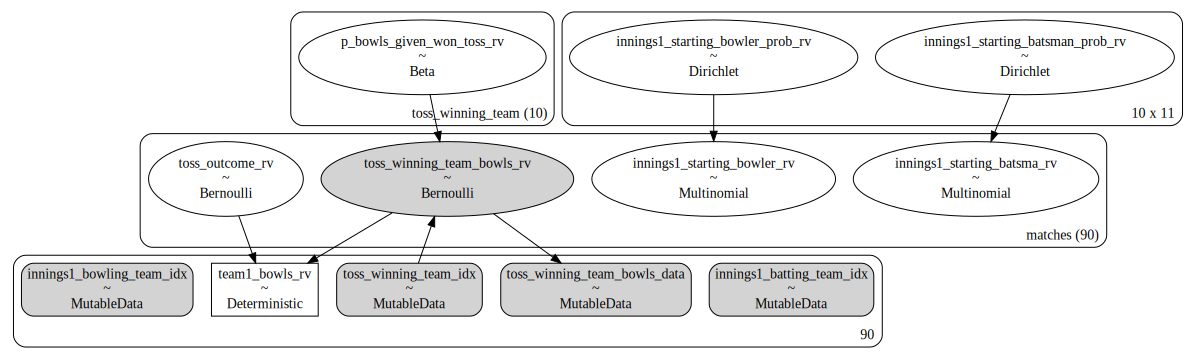

In [162]:

with pm.Model(coords = COORDS) as innings_layout_model_complex:
    toss_winning_team_bowls_data = pm.MutableData("toss_winning_team_bowls_data",
                                                  matches_df.toss_winning_team_bowls.values)
    toss_winning_team_idx_ = pm.MutableData("toss_winning_team_idx",
                                            toss_winning_team_idx)
    innings1_batting_team_idx_ = pm.MutableData("innings1_batting_team_idx",
                                                innings1_batting_team_idx)
    innings1_bowling_team_idx_ = pm.MutableData("innings1_bowling_team_idx",
                                                innings1_bowling_team_idx)
    toss_outcome_rv = pm.Bernoulli("toss_outcome_rv",
                                   p=0.5,
                                   dims = "matches")
    p_bowls_given_won_toss_rv = pm.Beta('p_bowls_given_won_toss_rv',
                                        2,
                                        10,
                                        dims = "toss_winning_team")
    toss_winning_team_bowls_rv = pm.Bernoulli("toss_winning_team_bowls_rv",
                                              p = p_bowls_given_won_toss_rv[toss_winning_team_idx_],
                                              dims = "matches",
                                              observed = toss_winning_team_bowls_data)
    team1_bowls_rv = pm.Deterministic("team1_bowls_rv",
                                      toss_outcome_rv*toss_winning_team_bowls_rv)
    innings1_starting_batsman_prob_rv = pm.Dirichlet("innings1_starting_batsman_prob_rv",
                                                    a = np.ones(shape=(len(team),
                                                                       11)))
    innings1_starting_batsman_rv = pm.Multinomial("innings1_starting_batsma_rv",
                                               n = 1,
                                               p = innings1_starting_batsman_prob_rv[innings1_batting_team_idx],
                                               dims = "matches")
    innings1_starting_bowler_prob_rv = pm.Dirichlet("innings1_starting_bowler_prob_rv",
                                                    a = np.ones(shape = (len(team),11)))
    innings1_starting_bowler_rv = pm.Multinomial("innings1_starting_bowler_rv",
                                                 n = 1,
                                                 p = innings1_starting_bowler_prob_rv[innings1_bowling_team_idx],
                                                 dims = "matches")
    

pm.model_to_graphviz(innings_layout_model_complex)

In [163]:
with innings_layout_model_complex:
    idata = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [toss_outcome_rv]
>NUTS: [p_bowls_given_won_toss_rv, innings1_starting_batsman_prob_rv, innings1_starting_bowler_prob_rv]
>CompoundStep
>>Metropolis: [innings1_starting_batsma_rv]
>>Metropolis: [innings1_starting_bowler_rv]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.


In [166]:
innings1_starting_batsman_prob_rv_post = idata.posterior.stack(draws=("chain", "draw"))["innings1_starting_batsman_prob_rv"].values
innings1_starting_batsman_rv_post = idata.posterior.stack(draws=("chain", "draw"))["innings1_starting_batsma_rv"].values

In [180]:
innings1_starting_batsman_prob_rv_post[0,:,1000]*100

array([4.21e+01, 4.75e-01, 7.86e+00, 7.98e+00, 2.35e+01, 5.47e-03,
       1.92e-01, 1.02e+00, 4.00e+00, 5.84e+00, 7.07e+00])

In [102]:
p_bowls_given_won_toss_rv_post = idata.posterior.stack(draws=("chain", "draw"))["p_bowls_given_won_toss_rv"].values

In [103]:
p_bowls_given_won_toss_rv_post.shape

(10, 4000)

KeyboardInterrupt: 

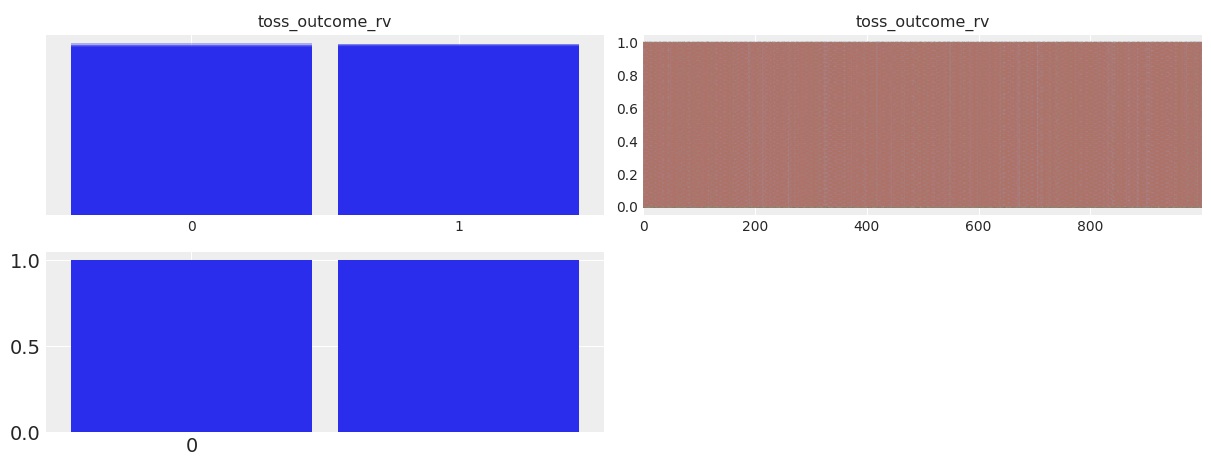

In [155]:
az.plot_trace(idata)

In [105]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [86]:
toss_winning_team

Int64Index([0, 3, 4, 5, 6, 7, 8, 9, 1, 2], dtype='int64')

In [106]:
team1_bowls_rv_post = idata.posterior.stack(draws=("chain", "draw"))["team1_bowls_rv"].values

In [108]:
team1_bowls_rv_post.shape

(90, 4000)

Text(0, 0.5, 'Plausible value count')

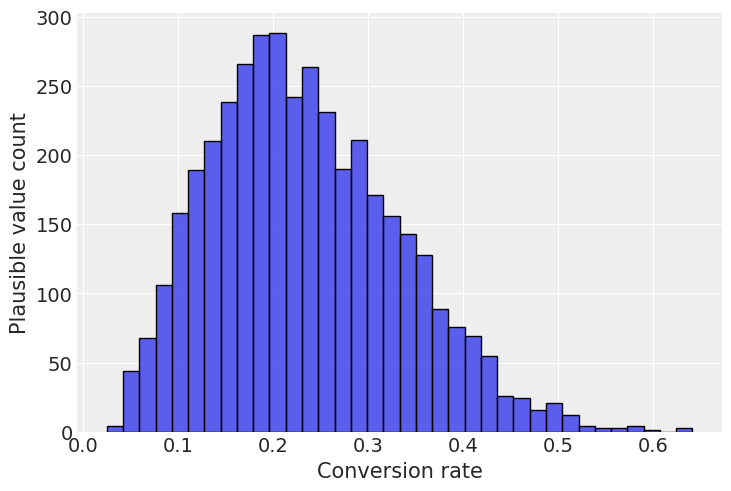

In [96]:
i = 0
ax = sns.histplot(p_bowls_given_won_toss_rv_post[i])
ax.set_xlabel("Conversion rate")
ax.set_ylabel("Plausible value count")

Text(0, 0.5, 'Plausible value count')

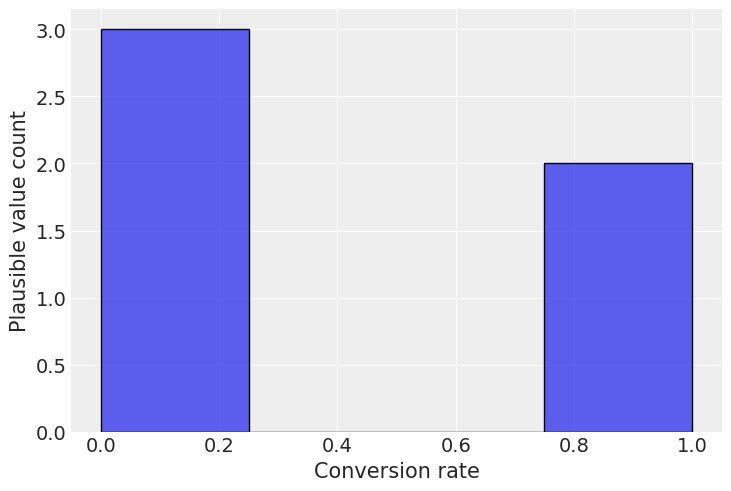

In [97]:
ax = sns.histplot(matches_df.loc[matches_df.toss_winning_team==i].toss_winning_team_bowls)
ax.set_xlabel("Conversion rate")
ax.set_ylabel("Plausible value count")

In [62]:
idata.observed_data.stack()['toss_winning_team_bowls_rv']

<xarray.DataArray 'toss_winning_team_bowls_rv' (matches: 90)>
array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])
Coordinates:
  * matches  (matches) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89